<a href="https://colab.research.google.com/github/Ajjme/Feedback_Systems/blob/main/Flash_Flood_CAT_Model_SD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

mm-based modeling:

Units are independent of basin size → model is scalable.

To get real volumetric flows just multiply the calculated depth by area
All stocks are in the unit mm of depth
all flows are mm/h

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# -----------------------------
# Set up rain storm: Rainfall: extreme pulse (mm/h)
# -----------------------------
def storm_hyetograph(time, start=1.0, peak=2.0, dur=3.0, R_peak=800.0): #these are default values?
    """
    Simple bell-shaped storm:
    - starts near 'start', peaks at 'peak', ends near 'start+dur'
    - R_peak in mm/h
    """
    sigma = dur / 6.0  # controls width
    R = R_peak * np.exp(-0.5 * ((time - peak) / sigma) ** 2)
    return R

In [5]:
# -----------------------------
# CAT model ODEs (flows in mm/h)
# -----------------------------
def cat_diff_eq(H, C, F, S, par, R_in): #take in states parameters and results from storm_hyetograph
    # Unpack parameters
    f_max   = par["f_max"]      # max infiltration uptake rate [1/h]
    a       = par["a"]          # exponent for (1 - saturation)
    k_run   = par["k_run"]      # runoff coeff [1/h]
    b       = par["b"]          # exponent for saturation
    tau_c   = par["tau_c"]      # channel residence time [h]
    C_cap   = par["C_cap"]      # levee capacity equivalent storage [mm]
    tau_over= par["tau_over"]   # overtopping time scale [h] # when over limit how quickly drain
    tau_fp  = par["tau_fp"]     # floodplain drainage time [h]
    k_perc  = par["k_perc"]     # soil percolation rate [1/h]
    S_max   = par["S_max"]      # soil water capacity [mm]

    # Soil saturation feedback
    sat = np.clip(S / S_max, 0.0, 1.0) #0 is bone dry 1 is fully saturated #np.clip just keeps the values between the given params
    #this value is fed into equations below as sat goes up infiltration goes to zero
    # S changes over time

    # Flows
    Infiltration = f_max * (1 - sat) ** a * H          # mm/h #enteres soil stock and
    Runoff       = k_run * sat ** b * H                # mm/h # from hillslope to channel
    Routing      = C / tau_c                           # mm/h to outlet # water leaving channel toward the outlet #leaves the stock system completely
    Overtopping  = np.maximum(0.0, (C - C_cap)) / tau_over # water spilling over levees into floodplain
    FP_return    = F / tau_fp                          # drain back to channel from Floodplains
    Percolation  = k_perc * S                          # ground water absorbsion

    # State derivatives
    dH_dt = R_in - Infiltration - Runoff
    dS_dt = Infiltration - Percolation
    dC_dt = Runoff + FP_return - Routing - Overtopping
    dF_dt = Overtopping - FP_return

    flows = {
        "R": R_in,
        "Infiltration": Infiltration,
        "Runoff": Runoff,
        "Routing": Routing,
        "Overtopping": Overtopping,
        "FP_return": FP_return,
        "Percolation": Percolation,
        "sat": sat
    }
    return dH_dt, dC_dt, dF_dt, dS_dt, flows


In [11]:
# -----------------------------
# Parameters & simulation setup
# -----------------------------
par = {
    # Infiltration / runoff feedback
    "f_max": 2.0,     # 1/h  (max soil intake when dry)
    # Humid small catchment (loam/clay soils): 0.5 – 10 mm/h (Ks lower for fine soils; infiltration-limited only for very intense storms).
    # Arid / sandy small catchment: 5 – 200 mm/h (sandy soils have high Ks but surface crusting in arid regions can reduce effective infiltration — see MDPI study).
    "a": 2.0,         # stronger drop as sat rises
    # Humid: typically 1 – 3 (soils retain some capacity until high sat).
    # Arid: 2 – 4 (if crusting/sealing is present, infiltration capacity can drop quickly).
    "k_run": 1.0,     # 1/h  (faster surface runoff as H accumulates)
    "b": 3.0,         # sharp increase near saturation
    # k_run (base runoff rate): 0.1 – 5 1/h (small flashy basins often near 0.5–2 1/h; urbanized/rocky areas toward the high end).
    # b (nonlinearity): 1 – 5; choose b≈1–2 for gradual increase, b≥3 for switch-like saturation-excess behavior that suddenly produces runoff as sat→1.
    # Humid: (k_run ~ 0.1–1, b ~ 1–3) — more variable source-area behavior.
    # Arid / steep: (k_run ~ 0.5–5, b ~ 2–5) — tends to be flashier when soils saturate or when overland flow is infiltration-excess. Tarboton discusses this mechanistic difference.


    # Channel / floodplain
    "tau_c": 2.0,     # h # channel routing time constant (linear reservoir)
    #Small, flashy catchment (<100 km²): 0.1 – 6 h (very flashy headwater basins: 0.1–2 h; modest small basins: 2–6 h).
    "C_cap": 80.0,    # mm of channel storage before overtopping #site specific
    "tau_over": 0.3,  # h (fast spill when above levee)
    # Typical: 0.01 – 1 h.
    # Very rapid overtopping/spill: <0.1 h (minutes) — catastrophic overtopping.
    # Slow spill or controlled overflow: 0.1 – 1 h.
    "tau_fp": 8.0,    # h (slow floodplain drainage)
    # Range: 1 – 200+ h (hours to many days) depending on floodplain geometry and connectivity.
    # Small, connected floodplains: 1 – 24 h.
    # Large backwater or low-gradient floodplains: 24 – 200+ h.


    # Soil
    "k_perc": 0.02,   # 1/h (deep percolation)
    # Typical: 0.001 – 0.1 1/h.
    # Fine-textured soils / shallow profiles: 0.001 – 0.01 1/h (very slow).
    # Sandy / coarse soils: 0.01 – 0.1 1/h.
    "S_max": 80.0     # mm (soil water capacity)
    # Typical ranges for small basins:
    # Humid (deeper soils): 100 – 300 mm
    # Arid / shallow soils: 10 – 100 mm
}

dt   = 0.005   # h  (≈18 s)
#rule of thumb make sure dt is 1/10 the shortest time scale in formulas (tau_over)
tmax = 24.0    # h
time = np.arange(0, tmax, dt)
n    = len(time)

# Initial conditions (dry-ish basin)
#set initial values to override zeros if you want
H = np.zeros(n)  # hillslope surface water (mm) (Could assume hilltop has some water)
H[0] = 10.0  # mm of water initially in hillslope
C = np.zeros(n)  # channel storage (mm) # this is where the water is supposed to be
F = np.zeros(n)  # floodplain water (mm)
S = np.zeros(n)  # soil water (mm)
S[0] = 20.0  # mm soil water already present

# For plotting flows
R_in_arr        = np.zeros(n)
Infiltration_arr= np.zeros(n)
Runoff_arr      = np.zeros(n)
Routing_arr     = np.zeros(n)
Overtop_arr     = np.zeros(n)
FPret_arr       = np.zeros(n)
Perc_arr        = np.zeros(n)
Sat_arr         = np.zeros(n)

In [12]:
# -----------------------------
# Euler integration
# -----------------------------
for t in range(1, n):
    R_in = storm_hyetograph(time[t], start=1.0, peak=2.0, dur=3.0, R_peak=800.0)
    dH, dC, dF, dS, flows = cat_diff_eq(H[t-1], C[t-1], F[t-1], S[t-1], par, R_in)

    H[t] = H[t-1] + dH * dt
    C[t] = C[t-1] + dC * dt
    F[t] = F[t-1] + dF * dt
    S[t] = S[t-1] + dS * dt

    # Enforce non-negativity
    H[t] = max(H[t], 0.0)
    C[t] = max(C[t], 0.0)
    F[t] = max(F[t], 0.0)
    S[t] = np.clip(S[t], 0.0, par["S_max"])

    # Log flows
    R_in_arr[t]         = flows["R"]
    Infiltration_arr[t] = flows["Infiltration"]
    Runoff_arr[t]       = flows["Runoff"]
    Routing_arr[t]      = flows["Routing"]
    Overtop_arr[t]      = flows["Overtopping"]
    FPret_arr[t]        = flows["FP_return"]
    Perc_arr[t]         = flows["Percolation"]
    Sat_arr[t]          = flows["sat"]


Peak channel storage: 180.3 mm at t = 3.00 h
Peak floodplain storage: 540.5 mm at t = 5.79 h


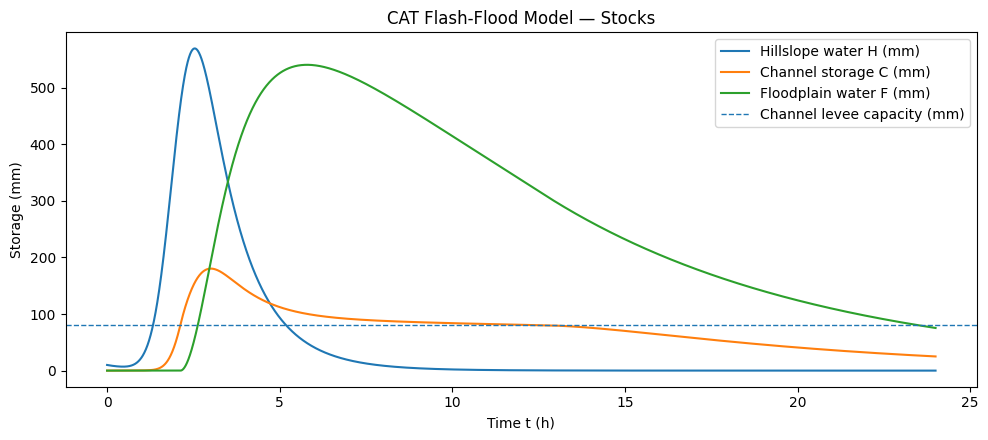

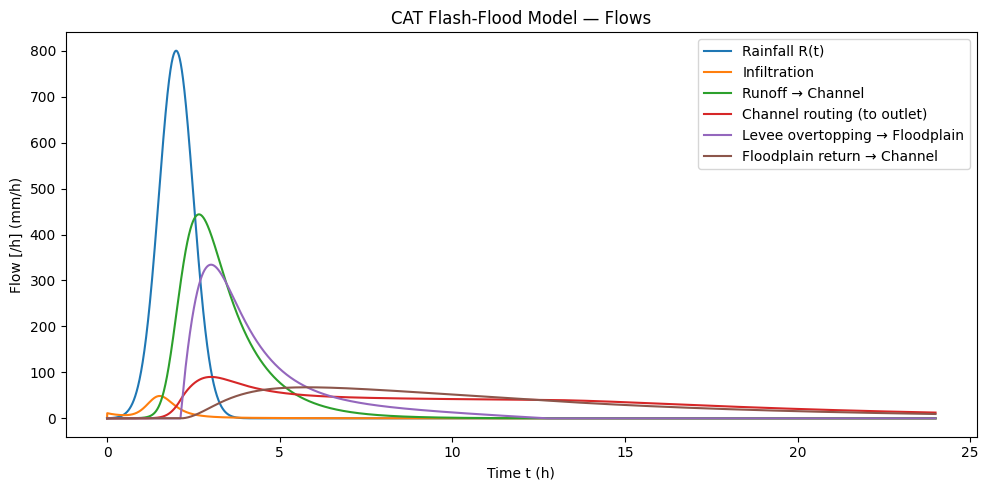

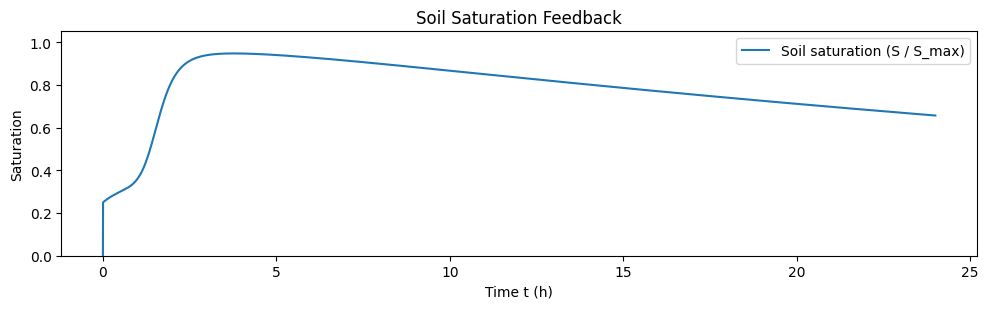

In [13]:
# -----------------------------
# Simple diagnostics
# -----------------------------
t_peak_F = time[np.argmax(F)]
t_peak_C = time[np.argmax(C)]
peak_F   = F.max()
peak_C   = C.max()

print(f"Peak channel storage: {peak_C:.1f} mm at t = {t_peak_C:.2f} h")
print(f"Peak floodplain storage: {peak_F:.1f} mm at t = {t_peak_F:.2f} h")

# -----------------------------
# Plots
# -----------------------------
# Stocks
plt.figure(figsize=(10, 4.5))
plt.plot(time, H, label="Hillslope water H (mm)")
plt.plot(time, C, label="Channel storage C (mm)")
plt.plot(time, F, label="Floodplain water F (mm)")
plt.axhline(par["C_cap"], linestyle="--", linewidth=1, label="Channel levee capacity (mm)")
plt.xlabel("Time t (h)")
plt.ylabel("Storage (mm)")
plt.title("CAT Flash-Flood Model — Stocks")
plt.legend()
plt.tight_layout()
plt.show()

# Flows (mm/h): rainfall, infiltration, runoff, routing, overtopping, floodplain return
plt.figure(figsize=(10, 5))
plt.plot(time, R_in_arr, label="Rainfall R(t)")
plt.plot(time, Infiltration_arr, label="Infiltration")
plt.plot(time, Runoff_arr, label="Runoff → Channel")
plt.plot(time, Routing_arr, label="Channel routing (to outlet)")
plt.plot(time, Overtop_arr, label="Levee overtopping → Floodplain")
plt.plot(time, FPret_arr, label="Floodplain return → Channel")
plt.xlabel("Time t (h)")
plt.ylabel("Flow [/h] (mm/h)")
plt.title("CAT Flash-Flood Model — Flows")
plt.legend()
plt.tight_layout()
plt.show()

# Soil saturation (feedback driver)
plt.figure(figsize=(10, 3.2))
plt.plot(time, Sat_arr, label="Soil saturation (S / S_max)")
plt.xlabel("Time t (h)")
plt.ylabel("Saturation")
plt.ylim(0, 1.05)
plt.title("Soil Saturation Feedback")
plt.legend()
plt.tight_layout()
plt.show()

Make overtopping happen sooner: decrease C_cap or tau_over, or increase tau_c (slower routing → bigger channel buildup).

Make basin “flashier”: increase k_run and exponent b, and decrease f_max or raise a to reduce infiltration when soils are moist.

Soils: raise S_max for deeper soils (more infiltration before saturation); increase k_perc to drain soils faster (less saturation feedback during long events).

In [14]:
#example code to add volumne of runoff
A = 1000
Q_runoff = flows.Runoff * A / 1000 / 3600  # mm/h → m³/s


AttributeError: 'dict' object has no attribute 'Runoff'